# Severn Influence of Height Case Study

## Table of contents
[1 Compute flood events](#compute-flood-events)  
[2 Required functions](#functions-needed-to-plot-data)  
[3 Make plots](#make-plots)

In [44]:
import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray

import pyextremes

import matplotlib.pyplot as plt


In [45]:
RIVER_NAME = "River Tweed"
RIVER_EASTING_RANGE = [250000, 415000]
RIVER_NORTHING_RANGE = [590000, 672000]

RIVER_ID_TO_NAMES = {"Fruid Water": 21001,"Norham": 21009, "Kingledores": 21014}

In [46]:
PATH_TO_HADUK = "../../../HadUK_Grid/haduk_grid_1km_day/"

# Load Data
For NRFA stations, catchments, and rivers data & CEH-GEAR and HadUK-Grid rainfall data

In [47]:
## NRFA station metadata
nrfa_station_metadata = pd.read_csv('../NRFA_Stations/nrfa_stations_data.csv', index_col=0)

## Big catchments
norham_station = nrfa_station_metadata.loc[nrfa_station_metadata['STATION'] == RIVER_ID_TO_NAMES["Norham"]]

## High altitude catchments
fruid_station = nrfa_station_metadata.loc[nrfa_station_metadata['STATION'] == RIVER_ID_TO_NAMES["Fruid Water"]]
kingledores_station = nrfa_station_metadata.loc[nrfa_station_metadata['STATION'] == RIVER_ID_TO_NAMES["Kingledores"]]

In [48]:
## Gauged daily flow (gdf)
## units: m^3 s^-1 (cumecs)
norham_gdf = pd.read_csv('Catchment_Data/Norham/21009_gdf.csv', skiprows=20, usecols=[0, 1], names=['date', 'gdf'], parse_dates=['date'])
peebles_gdf = pd.read_csv('Catchment_Data/Peebles/21003_gdf.csv', skiprows=20, usecols=[0, 1], names=['date', 'gdf'], parse_dates=['date'])

fruid_gdf = pd.read_csv('Catchment_Data/Fruid Water/21001_gdf.csv', skiprows=20, usecols=[0, 1], names=['date', 'gdf'], parse_dates=['date'])
kingledores_gdf = pd.read_csv('Catchment_Data/Kingledores/21014_gdf.csv', skiprows=20, usecols=[0, 1], names=['date', 'gdf'], parse_dates=['date'])

In [49]:
haduk_201601 = xr.open_dataset(f'{PATH_TO_HADUK}/rainfall_hadukgrid_uk_1km_day_20160101-20160131.nc').sel(projection_x_coordinate=slice(*RIVER_EASTING_RANGE),
                                                                                                    projection_y_coordinate=slice(*RIVER_NORTHING_RANGE))
haduk_201811 = xr.open_dataset(f'{PATH_TO_HADUK}/rainfall_hadukgrid_uk_1km_day_20181101-20181130.nc').sel(projection_x_coordinate=slice(*RIVER_EASTING_RANGE),
                                                                                                    projection_y_coordinate=slice(*RIVER_NORTHING_RANGE))
haduk_202001 = xr.open_dataset(f'{PATH_TO_HADUK}/rainfall_hadukgrid_uk_1km_day_20200101-20200131.nc').sel(projection_x_coordinate=slice(*RIVER_EASTING_RANGE),
                                                                                                    projection_y_coordinate=slice(*RIVER_NORTHING_RANGE))
haduk_202102 = xr.open_dataset(f'{PATH_TO_HADUK}/rainfall_hadukgrid_uk_1km_day_20210201-20210228.nc').sel(projection_x_coordinate=slice(*RIVER_EASTING_RANGE),
                                                                                                    projection_y_coordinate=slice(*RIVER_NORTHING_RANGE))
haduk_202212 = xr.open_dataset(f'{PATH_TO_HADUK}/rainfall_hadukgrid_uk_1km_day_20221201-20221231.nc').sel(projection_x_coordinate=slice(*RIVER_EASTING_RANGE),
                                                                                                    projection_y_coordinate=slice(*RIVER_NORTHING_RANGE))

In [50]:
norham_shp = gpd.read_file('Catchment_Data/Norham/21009/21009.shp')

fruid_shp = gpd.read_file('Catchment_Data/Fruid Water/21001/21001.shp')
kingledores_shp = gpd.read_file('Catchment_Data/Kingledores/21014/21014.shp')

In [51]:
tweed_hght = rioxarray.open_rasterio('Catchment_Data/HGHT_TWEED_1km.tif')
tweed_hght = tweed_hght.sortby('y')
tweed_hght = tweed_hght.sel(band=1)

# Compute flood events
get dates when 'floods' occured based on 95th Peaks Over Threshold

In [52]:
def compute_flood_event_dates(gdf_data, q=.95):
    q95 = gdf_data['gdf'].quantile(q)
    return pyextremes.get_extremes(gdf_data.set_index('date')['gdf'], 'POT', threshold=q95).index

In [53]:
norham_flood = compute_flood_event_dates(norham_gdf, q=.99)
peebles_flood = compute_flood_event_dates(peebles_gdf, q=.99)

fruid_flood = compute_flood_event_dates(fruid_gdf, q=.99)
kingledores_flood = compute_flood_event_dates(kingledores_gdf, q=.99)

len(norham_flood), len(peebles_flood), len(fruid_flood), len(kingledores_flood)

(156, 166, 29, 181)

In [54]:
tweed_floods = set(norham_flood).intersection(set(peebles_flood))
print(f"Total of {len(tweed_floods)} flood events co-occuring across the catchments")

Total of 73 flood events co-occuring across the catchments


In [55]:
tweed_floods = sorted(list(tweed_floods))
tweed_floods[-10:]

[Timestamp('2015-12-30 00:00:00'),
 Timestamp('2016-01-10 00:00:00'),
 Timestamp('2018-01-24 00:00:00'),
 Timestamp('2018-11-29 00:00:00'),
 Timestamp('2020-01-11 00:00:00'),
 Timestamp('2020-02-09 00:00:00'),
 Timestamp('2021-02-20 00:00:00'),
 Timestamp('2021-10-28 00:00:00'),
 Timestamp('2022-02-20 00:00:00'),
 Timestamp('2022-12-30 00:00:00')]

In [56]:
## Flood events
flood201601 = tweed_floods[-9]
flood201811 = tweed_floods[-7]
flood202001 = tweed_floods[-6]
flood202102 = tweed_floods[-4]
flood202212 = tweed_floods[-1]

In [57]:
flood_data_dict = { "flood201601": {"date": flood201601, "data": haduk_201601},\
                    "flood201811": {"date": flood201811, "data": haduk_201811},\
                    "flood202001": {"date": flood202001, "data": haduk_202001},\
                    "flood202102": {"date": flood202102, "data": haduk_202102},\
                    "flood202212": {"date": flood202212, "data": haduk_202212}}

# Functions needed to plot data
[Back to ToC](#table-of-contents)

In [58]:
def make_region_hght_clip(region_shp, hght_data):
    region_clip = hght_data.rio.clip(region_shp.geometry.values, region_shp.crs, drop=False, invert=False)
    return region_clip

In [59]:
def coerse_data_into_haduk_format(one_day_data, offset, xrange, yrange):
    """
    Quick fix for coersing data to have same grid as HADUK.
    """
    one_day_data = one_day_data.assign_coords(x=(one_day_data['x'] + offset))
    one_day_data = one_day_data.assign_coords(y=(one_day_data['y'] + offset))
    one_day_data = one_day_data.sel(x=xrange, y=yrange)
    one_day_data = one_day_data.rename({'x': 'projection_x_coordinate', 'y': 'projection_y_coordinate'})
    return one_day_data


In [60]:
def make_region_mask(region_data):
    """
    Make binary mask of clipped region data data
    """
    return (region_data/region_data.where(region_data>0))

In [61]:
TWEED_XRANGE = slice(250500, 414550)
TWEED_YRANGE = slice(590500, 671550)

In [62]:
def mask_region_rainfall(rainfall_data, region_mask):
    return rainfall_data * region_mask.data


def mask_region_rainfall_by_hght(rainfall_data, region_hght, threshold):
    region_hght_mask = region_hght/region_hght.where(region_hght > threshold)
    region_hght_mask_fmt = coerse_data_into_haduk_format(region_hght_mask, offset=25, xrange=TWEED_XRANGE, yrange=TWEED_YRANGE)
    return rainfall_data * region_hght_mask_fmt.data

def sum_region_rainfall(rainfall_data):
    if 'time' in rainfall_data.dims:
        if rainfall_data.time.size > 1:
            return rainfall_data.sum('time')
    return rainfall_data.sum()

def calc_prop_rainfall_over_region(rainfall_data):
    if 'time' in rainfall_data.dims:
        if rainfall_data.time.size > 1:
            return rainfall_data.groupby('time').apply(lambda row: row/row.sum())
    return rainfall_data/rainfall_data.sum()

# Make plots
[Back to ToC](#table-of-contents)

In [63]:
flood_data_dict.keys()

dict_keys(['flood201601', 'flood201811', 'flood202001', 'flood202102', 'flood202212'])

In [64]:
flood_to_examine = flood_data_dict["flood202212"]
flood_date = flood_to_examine["date"]
haduk_data = flood_to_examine["data"]
days_before_flood = 9 # 6 == 7 days before

In [65]:
def run_prop_rainfall_analysis(region_shp, flood_date, days_before_flood, haduk_data, hght_data):
    region_hght = make_region_hght_clip(region_shp, hght_data=hght_data)
    region_clip_fmt = coerse_data_into_haduk_format(region_hght, offset=25, xrange=TWEED_XRANGE, yrange=TWEED_YRANGE)
    region_mask = make_region_mask(region_clip_fmt)

    haduk_region_mask = mask_region_rainfall(haduk_data['rainfall'], region_mask)
    haduk_region_daysbefore_mask = haduk_region_mask.sel(time=slice((\
                                    flood_date-datetime.timedelta(days=days_before_flood)).strftime("%Y-%m-%d"),\
                                    flood_date.strftime("%Y-%m-%d")))
    haduk_region_mask_sum_prop = calc_prop_rainfall_over_region(sum_region_rainfall(haduk_region_daysbefore_mask))
    return haduk_region_mask_sum_prop

In [66]:
haduk_norham_mask_sum_prop = run_prop_rainfall_analysis(region_shp=norham_shp,\
                                                         flood_date=flood_date,\
                                                         days_before_flood=days_before_flood,
                                                         haduk_data=haduk_data,\
                                                         hght_data=tweed_hght)

In [67]:
haduk_kingledores_mask_sum_prop = run_prop_rainfall_analysis(region_shp=kingledores_shp,\
                                                         flood_date=flood_date,\
                                                         days_before_flood=days_before_flood,
                                                         haduk_data=haduk_data,\
                                                         hght_data=tweed_hght)

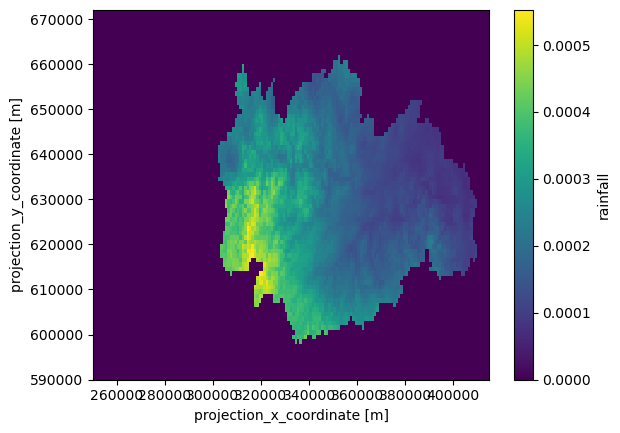

In [68]:
haduk_norham_mask_sum_prop.plot()

(295000.0, 324000.0)

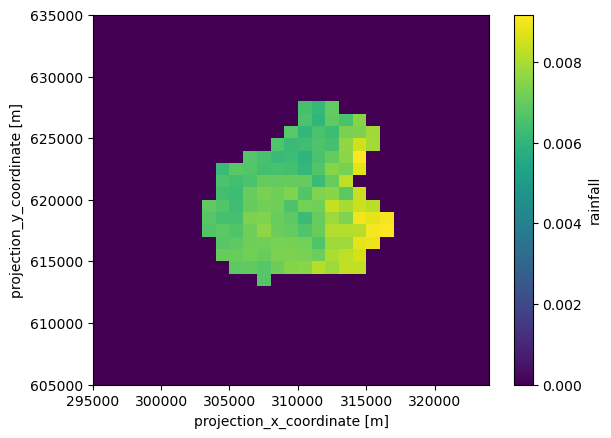

In [69]:
haduk_kingledores_mask_sum_prop.plot()
plt.ylim(605000, 635000)
plt.xlim(295000, 324000)

### Now mask by height

In [70]:
height_buffer = 0 # 500 == add 50 metres
norham_station_height = norham_station['HGHT'].values[0]

kingledores_station_height = kingledores_station['HGHT'].values[0]
fruid_station_height = fruid_station['HGHT'].values[0]

kingledores_station_height_buffer = kingledores_station_height+height_buffer
fruid_station_height_buffer = fruid_station_height+height_buffer

In [71]:
norham_hght = make_region_hght_clip(norham_shp, hght_data=tweed_hght)
haduk_norham_mask_sum_prop_above_kingledores = mask_region_rainfall_by_hght(haduk_norham_mask_sum_prop, norham_hght, threshold=kingledores_station_height_buffer)
haduk_norham_mask_sum_prop_above_fruid = mask_region_rainfall_by_hght(haduk_norham_mask_sum_prop, norham_hght, threshold=fruid_station_height_buffer)

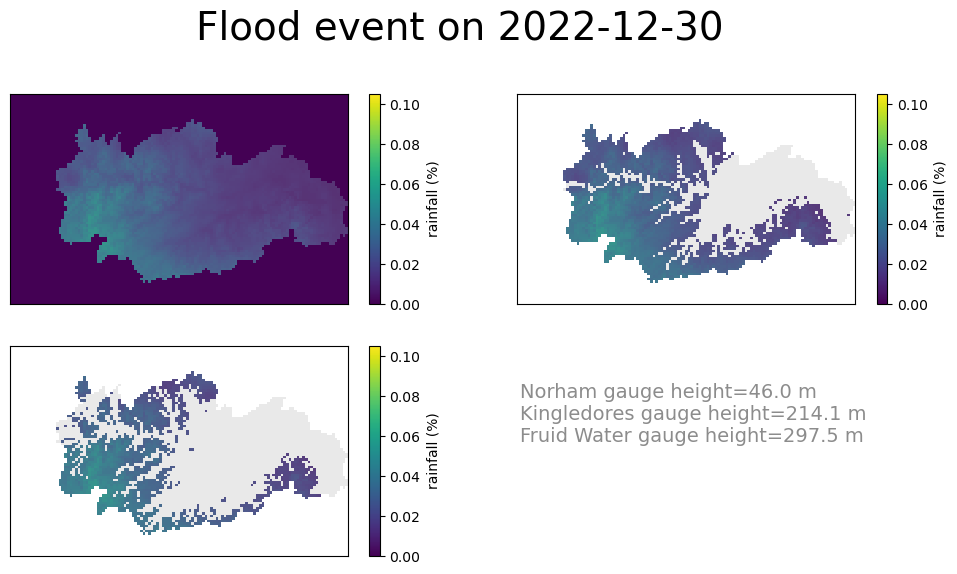

In [72]:
pnt_above_kingledores = (sum_region_rainfall(haduk_norham_mask_sum_prop_above_kingledores)*100).data.round(2)
pnt_above_fruid = (sum_region_rainfall(haduk_norham_mask_sum_prop_above_fruid)*100).data.round(2)
rain_prop_vmax = (haduk_norham_mask_sum_prop.max().round(5)*100+0.05)

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
(haduk_norham_mask_sum_prop*100).plot(ax=axes[0][0], vmin=0, vmax=rain_prop_vmax,\
                                 cbar_kwargs={'label':f'rainfall (%)'})
axes[0][0].set_title(f'Rainfall across Norham catchment \n (sum of -{days_before_flood+1} to 0 days) ');
(haduk_norham_mask_sum_prop_above_kingledores*100).plot(ax=axes[0][1], vmin=0, vmax=rain_prop_vmax,\
                                              cbar_kwargs={'label':f'rainfall (%)'})
axes[0][1].set_title(f'Rainfall above {kingledores_station_height_buffer/10} m: {pnt_above_kingledores} %');
(haduk_norham_mask_sum_prop_above_fruid*100).plot(ax=axes[1][0], vmin=0, vmax=rain_prop_vmax,\
                                                 cbar_kwargs={'label':f'rainfall (%)'})
axes[1][0].set_title(f'Rainfall above height of {fruid_station_height_buffer/10} m: {pnt_above_fruid} %');

axes[1][1].remove()

for ind, ax in enumerate(axes.flatten()):
    if ind == 3:
        continue
    (haduk_norham_mask_sum_prop/haduk_norham_mask_sum_prop).plot(cmap='Greys', alpha=.2, ax=ax, add_colorbar=False)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticks([]); ax.set_yticks([]);
    ax.set_xlim(285000, 410000)
plt.suptitle(f'Flood event on {flood_date.strftime("%Y-%m-%d")}', y=1.02, size=28)
fig.text(s=f'Norham gauge height={norham_station_height} m\nKingledores gauge height={kingledores_station_height/10} m\nFruid Water gauge height={fruid_station_height/10} m',\
          x=.55, y=.3, color='grey', alpha=.9, size=14)

fig.subplots_adjust(hspace=.2)
# plt.savefig(f'Figures/norham_{flood_date.strftime('%Y_%m_%d')}_{days_before_flood+1}d_prop_rain.png',\
#             bbox_inches='tight', dpi=200)

## Repeat for 5-flood average

In [73]:
norham_hght = make_region_hght_clip(norham_shp, hght_data=tweed_hght)
days_before_flood = 9 # 6 == 7 days before

In [74]:
for ind, flood_name in enumerate(flood_data_dict.keys()):
    flood_to_examine = flood_data_dict[flood_name]
    flood_date = flood_to_examine["date"]
    haduk_data = flood_to_examine["data"]

    haduk_norham_mask_sum_prop = run_prop_rainfall_analysis(region_shp=norham_shp,\
                                                         flood_date=flood_date,\
                                                         days_before_flood=days_before_flood,
                                                         haduk_data=haduk_data,\
                                                         hght_data=tweed_hght)
    if ind == 0:
        total_norham_mask_sum_prop = haduk_norham_mask_sum_prop
    else:
        total_norham_mask_sum_prop += haduk_norham_mask_sum_prop


In [75]:
mean_norham_mask_sum_prop = total_norham_mask_sum_prop/len(flood_data_dict)

In [76]:
mean_norham_mask_sum_prop_above_kingledores = mask_region_rainfall_by_hght(mean_norham_mask_sum_prop, norham_hght, threshold=kingledores_station_height_buffer)
mean_norham_mask_sum_prop_above_fruid = mask_region_rainfall_by_hght(mean_norham_mask_sum_prop, norham_hght, threshold=fruid_station_height_buffer)

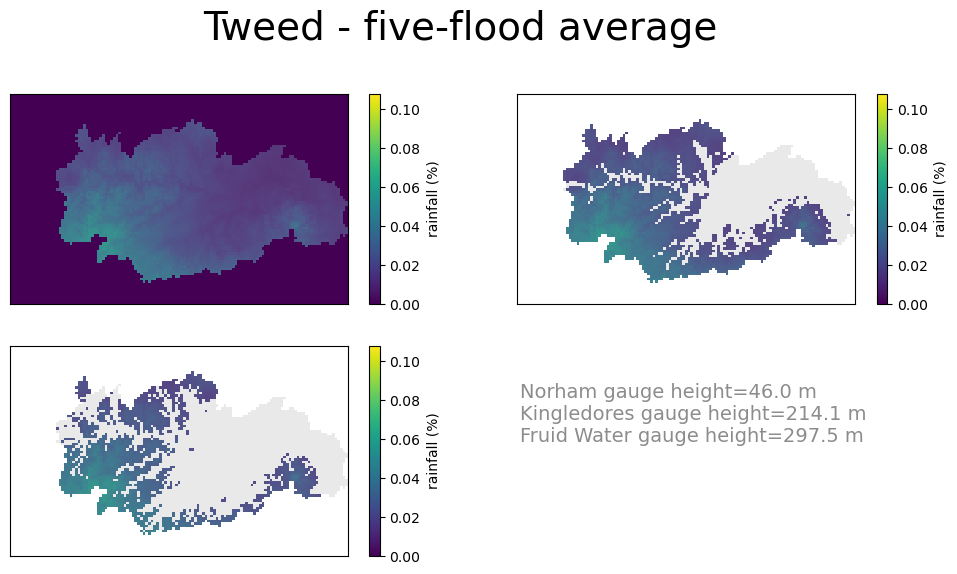

In [77]:
mean_pnt_above_kingledores = (sum_region_rainfall(mean_norham_mask_sum_prop_above_kingledores)*100).data.round(2)
mean_pnt_above_fruid = (sum_region_rainfall(mean_norham_mask_sum_prop_above_fruid)*100).data.round(2)
mean_rain_prop_vmax = (mean_norham_mask_sum_prop.max().round(5)*100+0.05)


fig, axes = plt.subplots(2, 2, figsize=(12, 6))
(mean_norham_mask_sum_prop*100).plot(ax=axes[0][0], vmin=0, vmax=mean_rain_prop_vmax,\
                                 cbar_kwargs={'label':f'rainfall (%)'})
axes[0][0].set_title(f'Rainfall across Norham catchment \n (sum of -{days_before_flood+1} to 0 days) ');
(mean_norham_mask_sum_prop_above_kingledores*100).plot(ax=axes[0][1], vmin=0, vmax=mean_rain_prop_vmax,\
                                              cbar_kwargs={'label':f'rainfall (%)'})
axes[0][1].set_title(f'Rainfall above {kingledores_station_height_buffer/10} m: {mean_pnt_above_kingledores} %');
(mean_norham_mask_sum_prop_above_fruid*100).plot(ax=axes[1][0], vmin=0, vmax=mean_rain_prop_vmax,\
                                                 cbar_kwargs={'label':f'rainfall (%)'})
axes[1][0].set_title(f'Rainfall above height of {fruid_station_height_buffer/10} m: {mean_pnt_above_fruid} %');

axes[1][1].remove()

for ind, ax in enumerate(axes.flatten()):
    if ind == 3:
        continue
    (mean_norham_mask_sum_prop/mean_norham_mask_sum_prop).plot(cmap='Greys', alpha=.2, ax=ax, add_colorbar=False)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticks([]); ax.set_yticks([]);
    ax.set_xlim(285000, 410000)
plt.suptitle(f'Tweed - five-flood average', y=1.02, size=28)
fig.text(s=f'Norham gauge height={norham_station_height} m\nKingledores gauge height={kingledores_station_height/10} m\nFruid Water gauge height={fruid_station_height/10} m',\
          x=.55, y=.3, color='grey', alpha=.9, size=14)

fig.subplots_adjust(hspace=.2)
# plt.savefig(f'Figures/fiveflood_mean_norham_{days_before_flood+1}d_prop_rain.png',\
#             bbox_inches='tight', dpi=200)

## Look at influence of height threshold

In [78]:
flood_to_examine = flood_data_dict["flood202001"]
days_before_flood = 9 # 9 == 10 days before

In [79]:
def calc_percentage_grid_cells_above_thresh(haduk_shp_mask_sum_prop, haduk_shp_mask_sum_prop_above_thresh):
    total_grid_cells = (haduk_shp_mask_sum_prop/haduk_shp_mask_sum_prop).sum()
    above_thresh_grid_cells = (haduk_shp_mask_sum_prop_above_thresh/haduk_shp_mask_sum_prop_above_thresh).sum()
    return ((above_thresh_grid_cells)/total_grid_cells)*100

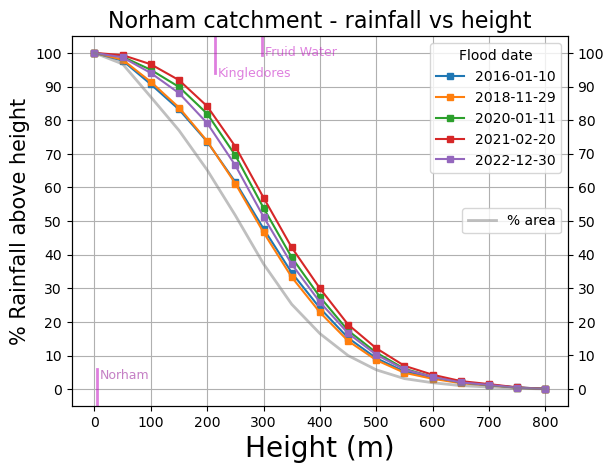

In [87]:
fig, ax = plt.subplots(1)
for flood_names in flood_data_dict.keys():
    flood_to_examine = flood_data_dict[flood_names]
    flood_date = flood_to_examine["date"]
    haduk_data = flood_to_examine["data"]
    haduk_norham_mask_sum_prop = run_prop_rainfall_analysis(region_shp=norham_shp,\
                                                            flood_date=flood_date,\
                                                            days_before_flood=days_before_flood,\
                                                            haduk_data=haduk_data,\
                                                            hght_data=tweed_hght)
    all_pnt_above_thresh = []
    all_num_cells = []
    height_thresholds = np.arange(0, norham_hght.max()+100, 500)
    for height_thresh in height_thresholds:
        haduk_norham_mask_sum_prop_above_thresh = mask_region_rainfall_by_hght(haduk_norham_mask_sum_prop, norham_hght, threshold=height_thresh)
        pnt_above_thresh = (sum_region_rainfall(haduk_norham_mask_sum_prop_above_thresh)*100).data.round(2)
        all_pnt_above_thresh.append(pnt_above_thresh)

        all_num_cells.append(calc_percentage_grid_cells_above_thresh(haduk_norham_mask_sum_prop, haduk_norham_mask_sum_prop_above_thresh).data)
    # Plot
    ax.plot(height_thresholds/10, all_pnt_above_thresh, marker='s', markersize=4, label=f'{flood_date.strftime("%Y-%m-%d")}')
    ax.grid()
    ax.legend(title="Flood date")
    ax.set_xlabel("Height (m)", size=20)
    ax.set_ylabel("% Rainfall above height", size=15)
    ax.set_yticks(np.arange(0, 101, 10))
ax.axvline(x=norham_station_height/10, ymin=0, ymax=.1, c='m', alpha=.5, linewidth=2)
ax.axvline(x=kingledores_station_height/10, ymin=.9, ymax=1, c='m', alpha=.5, linewidth=2)
ax.axvline(x=fruid_station_height/10, ymin=.95, ymax=1, c='m', alpha=.5, linewidth=2)

ax.text(s="Norham", x=norham_station_height/10+5, y=3, alpha=.5, size=9, c='darkmagenta')
ax.text(s="Kingledores", x=kingledores_station_height/10+5, y=93, alpha=.5, size=9, c='m')
ax.text(s="Fruid Water", x=fruid_station_height/10+5, y=99, alpha=.5, size=9, c='m')

ax2 = ax.twinx()
ax2.plot(height_thresholds/10, all_num_cells, color='grey', linewidth=2, alpha=.5)
ax2.legend(["% area"], loc=5)
ax2.set_yticks(np.arange(0, 101, 10));
ax.set_title("Norham catchment - rainfall vs height", size=16)
# fig.savefig('figures/norham_all_floods_lineplot_threshold.png', bbox_inches='tight', dpi=300)

In [81]:
for flood_names in flood_data_dict.keys():
    flood_to_examine = flood_data_dict[flood_names]
    flood_date = flood_to_examine["date"]
    haduk_data = flood_to_examine["data"]
    haduk_norham_mask_sum_prop = run_prop_rainfall_analysis(region_shp=norham_shp,\
                                                            flood_date=flood_date,\
                                                            days_before_flood=days_before_flood,\
                                                            haduk_data=haduk_data,\
                                                            hght_data=tweed_hght)
    all_pnt_above_thresh = []
    all_num_cells = []
    height_thresholds = np.arange(0, norham_hght.max()+100, 500)
    for height_thresh in height_thresholds:
        haduk_norham_mask_sum_prop_above_thresh = mask_region_rainfall_by_hght(haduk_norham_mask_sum_prop, norham_hght, threshold=height_thresh)
        pnt_above_thresh = (sum_region_rainfall(haduk_norham_mask_sum_prop_above_thresh)*100).data.round(2)
        all_pnt_above_thresh.append(pnt_above_thresh)
        all_num_cells.append(calc_percentage_grid_cells_above_thresh(haduk_norham_mask_sum_prop, haduk_norham_mask_sum_prop_above_thresh).data)


    height_vs_rainfall_df = pd.DataFrame([height_thresholds//10, np.round(all_num_cells, 2), all_pnt_above_thresh]).T
    height_vs_rainfall_df.columns = ["Height (m)", "Area of catchment above that height (%)", "Rainfall (%)"]
    height_vs_rainfall_df['diff'] = np.round(height_vs_rainfall_df['Area of catchment above that height (%)'] - height_vs_rainfall_df['Rainfall (%)'], 2)
    # height_vs_rainfall_df.to_csv(f'Outputs/norham_{flood_date.strftime('%Y_%m_%d')}_height_vs_rainfall.csv', index=False)

### Compare average profile

In [82]:

for ind, flood_names in enumerate(flood_data_dict.keys()):
    flood_to_examine = flood_data_dict[flood_names]
    flood_date = flood_to_examine["date"]
    haduk_data = flood_to_examine["data"]
    height_vs_rainfall_df = pd.read_csv(f'Outputs/norham_{flood_date.strftime('%Y_%m_%d')}_height_vs_rainfall.csv')

    if ind == 0:
        overall_height_vs_rainfall_df = height_vs_rainfall_df
    else:
        overall_height_vs_rainfall_df += height_vs_rainfall_df

In [83]:
overall_height_vs_rainfall_df/len(flood_data_dict)

,Height (m),Area of catchment above that height (%),Rainfall (%),diff
0,0.0,100.00,100.000,0.000
1,50.0,96.71,98.510,-1.800
2,100.0,86.90,93.542,-6.642
3,150.0,76.95,87.358,-10.408
4,200.0,65.17,78.510,-13.340
5,250.0,51.66,66.194,-14.534
6,300.0,37.24,51.284,-14.044
7,350.0,25.23,37.286,-12.056
8,400.0,16.51,26.048,-9.538
9,450.0,9.97,16.570,-6.600


## Look at lead-up rainfall profile

In [84]:
num_lead_up_days = 15

Text(0.5, 1.0, 'Norham catchment - lead up days vs rain')

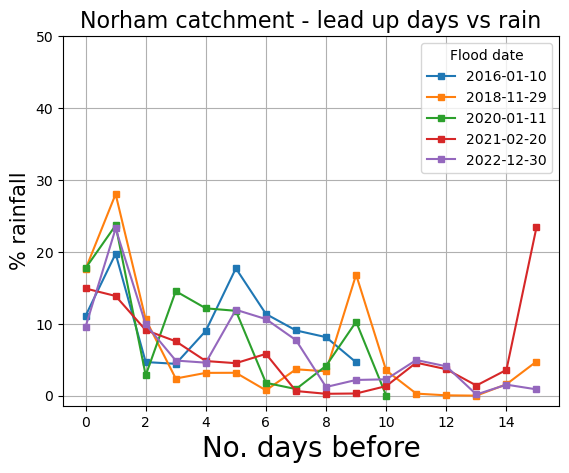

In [85]:
fig, ax = plt.subplots(1)
for flood_names in flood_data_dict.keys():
    flood_to_examine = flood_data_dict[flood_names]
    flood_date = flood_to_examine["date"]
    haduk_data = flood_to_examine["data"]

    haduk_daysbefore = haduk_data.sel(time=slice((\
                                flood_date-datetime.timedelta(days=num_lead_up_days)).strftime("%Y-%m-%d"),\
                                flood_date.strftime("%Y-%m-%d")))
    daily_total_rain = haduk_daysbefore['rainfall'].sum(('projection_x_coordinate', 'projection_y_coordinate'))
    pnt_total_rain = (daily_total_rain/daily_total_rain.sum())*100

    # Plot
    ax.plot(list(reversed(range(0, pnt_total_rain.data.shape[0]))), pnt_total_rain.data, marker='s', markersize=4, label=f'{flood_date.strftime("%Y-%m-%d")}')
    ax.grid()
    ax.legend(title="Flood date")
    ax.set_xlabel("No. days before", size=20)
    ax.set_ylabel("% rainfall", size=15)
    ax.set_yticks(np.arange(0, 51, 10))

ax.set_title("Norham catchment - lead up days vs rain", size=16)
# fig.savefig('figures/tweed_all_floods_leadupdays.png', bbox_inches='tight', dpi=300)

Text(0.5, 1.0, 'Norham catchment - lead up days vs rain')

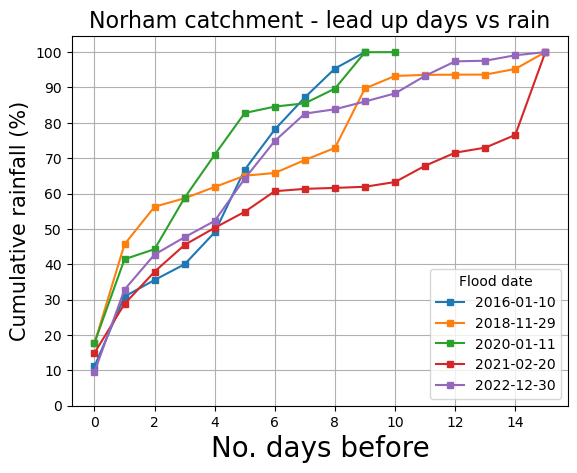

In [86]:
fig, ax = plt.subplots(1)
for flood_names in flood_data_dict.keys():
    flood_to_examine = flood_data_dict[flood_names]
    flood_date = flood_to_examine["date"]
    haduk_data = flood_to_examine["data"]

    haduk_daysbefore = haduk_data.sel(time=slice((\
                                flood_date-datetime.timedelta(days=num_lead_up_days)).strftime("%Y-%m-%d"),\
                                flood_date.strftime("%Y-%m-%d")))
    daily_total_rain = haduk_daysbefore['rainfall'].sum(('projection_x_coordinate', 'projection_y_coordinate'))
    pnt_total_rain = (daily_total_rain/daily_total_rain.sum())*100

    # Plot
    ax.plot(range(0, pnt_total_rain.data.shape[0]), np.cumsum(list(reversed(pnt_total_rain.data))), marker='s', markersize=4, label=f'{flood_date.strftime("%Y-%m-%d")}')
    ax.grid()
    ax.legend(title="Flood date")
    ax.set_xlabel("No. days before", size=20)
    ax.set_ylabel("Cumulative rainfall (%)", size=15)
    ax.set_yticks(np.arange(0, 101, 10))

ax.set_title("Norham catchment - lead up days vs rain", size=16)
# fig.savefig('figures/tweed_all_floods_leadupdays_cumulative.png', bbox_inches='tight', dpi=300)